In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author:Unknown

Functional autoencoder implementation
"""

# Import modules
import inspect
import random
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
from tqdm import tqdm
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B


In [2]:
import pandas as pd
import os
os.chdir("C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/Functionnal Classifier")
# Lire le fichier CSV
sofa = pd.read_csv('sofa.csv')
T=20
# Attribuer des noms de colonnes personnalisés


# Afficher les noms de colonnes
print(sofa.columns)
grid_points=np.arange(T+1)[1:]
sofa.values.shape


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173',
       'V174'],
      dtype='object', length=174)


(520, 174)

In [3]:
Y_X=torch.from_numpy(sofa.values).float().cuda()

y,x=Y_X[:,0].unsqueeze(1).unsqueeze(2).long(),Y_X[:,1:T+1].reshape(520,1,T)
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,shuffle=True)
x_train.shape,y_train.shape


(torch.Size([390, 1, 20]), torch.Size([390, 1, 1]))

In [4]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.07)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.07)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [5]:
n_epochs=25  
basis=B(knots=linspace(1,T,6),order=3)
n_conv_out=64
granulation=2000
n_conv_in=128
n_conv_in2=128
n_conv_in3=64
n_Flat_out=256
stride_1=6
stride_2=2
stride_3=1
stride_pool_1=2
stride_pool_2=2
stride_pool_3=1
kernel_size_1=200
kernel_size_2=50
kernel_size_3=20
kernel_size_pool_1=6
kernel_size_pool_2=4
kernel_size_pool_3=2
dilation_1=1
dilation_2=1
dilation_3=1
dilation_pool_1=1
dilation_pool_2=1
dilation_pool_3=1
padding_1=2
padding_2=2
padding_3=2
padding_pool_1=1
padding_pool_2=1
padding_pool_3=1
opt="Adam"
lr_adam=0.00089
lr_SGD=0.001
loss_function=nn.CrossEntropyLoss()
batch_size=96

In [6]:
class HyperParameters:
    def __init__(self,batch_size=96, n_epochs=25, basis=B(knots=linspace(1, T, 6), order=3), granulation=2000,
                 n_conv_in=128, n_conv_in2=128, n_conv_in3=64,n_conv_out=64, n_Flat_out=256,
                 stride_1=6, stride_2=2, stride_3=1,
                 stride_pool_1=2, stride_pool_2=2, stride_pool_3=1,
                 kernel_size_1=200, kernel_size_2=50, kernel_size_3=20,
                 kernel_size_pool_1=6, kernel_size_pool_2=4, kernel_size_pool_3=2,
                 dilation_1=1, dilation_2=1, dilation_3=1,
                 dilation_pool_1=1, dilation_pool_2=1, dilation_pool_3=1,
                 padding_1=2, padding_2=2, padding_3=2,
                 padding_pool_1=1, padding_pool_2=1, padding_pool_3=1,
                 opt="Adam", lr=0.00089, loss=nn.CrossEntropyLoss(),activation=nn.Identity()):
        self.n_epochs = n_epochs
        self.batch_size=batch_size
        self.activation=activation
        self.n_conv_out=n_conv_out
        self.basis = basis
        self.granulation = granulation
        self.n_conv_in = n_conv_in
        self.n_conv_in2 = n_conv_in2
        self.n_conv_in3 = n_conv_in3
        self.n_Flat_out = n_Flat_out
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.stride_3 = stride_3
        self.stride_pool_1 = stride_pool_1
        self.stride_pool_2 = stride_pool_2
        self.stride_pool_3 = stride_pool_3
        self.kernel_size_1 = kernel_size_1
        self.kernel_size_2 = kernel_size_2
        self.kernel_size_3 = kernel_size_3
        self.kernel_size_pool_1 = kernel_size_pool_1
        self.kernel_size_pool_2 = kernel_size_pool_2
        self.kernel_size_pool_3 = kernel_size_pool_3
        self.dilation_1 = dilation_1
        self.dilation_2 = dilation_2
        self.dilation_3 = dilation_3
        self.dilation_pool_1 = dilation_pool_1
        self.dilation_pool_2 = dilation_pool_2
        self.dilation_pool_3 = dilation_pool_3
        self.padding_1 = padding_1
        self.padding_2 = padding_2
        self.padding_3 = padding_3
        self.padding_pool_1 = padding_pool_1
        self.padding_pool_2 = padding_pool_2
        self.padding_pool_3 = padding_pool_3
        self.opt = opt
        self.lr = lr
        self.loss = loss


In [7]:
arguments_defaults = {
    "n_epochs": 25,
    "basis": B(knots=linspace(1,T,6),order=3),
    "granulation": 2000,
    "n_conv_in": 128,
    "n_conv_in2": 128,
    "n_conv_in3": 64,
    "n_Flat_out": 256,
    "stride_1": 6,
    "stride_2": 2,
    "stride_3": 1,
    "stride_pool_1": 2,
    "stride_pool_2": 2,
    "stride_pool_3": 1,
    "kernel_size_1": 200,
    "kernel_size_2": 50,
    "kernel_size_3": 20,
    "kernel_size_pool_1": 6,
    "kernel_size_pool_2": 4,
    "kernel_size_pool_3": 2,
    "dilation_1": 1,
    "dilation_2": 1,
    "dilation_3": 1,
    "dilation_pool_1": 1,
    "dilation_pool_2": 1,
    "dilation_pool_3": 1,
    "padding_1": 2,
    "padding_2": 2,
    "padding_3": 2,
    "padding_pool_1": 1,
    "padding_pool_2": 1,
    "padding_pool_3": 1,
    "opt": "Adam",
    "lr": 0.00089,
    "loss": nn.CrossEntropyLoss()
}


In [8]:
Defaults_arguments=HyperParameters()


In [40]:

class Smooth_Strides_FCNN(nn.Module):
    def __init__(self, hyperparams):
        super(Smooth_Strides_FCNN, self).__init__()

        basis = hyperparams.basis
        granulation = hyperparams.granulation
        n_conv_in = hyperparams.n_conv_in
        n_conv_in2 = hyperparams.n_conv_in2
        n_conv_in3 = hyperparams.n_conv_in3
        n_Flat_out = hyperparams.n_Flat_out
        stride_1 = hyperparams.stride_1
        stride_2 = hyperparams.stride_2
        stride_3 = hyperparams.stride_3
        stride_pool_1 = hyperparams.stride_pool_1
        stride_pool_2 = hyperparams.stride_pool_2
        stride_pool_3 = hyperparams.stride_pool_3
        kernel_size_1 = hyperparams.kernel_size_1
        kernel_size_2 = hyperparams.kernel_size_2
        kernel_size_3 = hyperparams.kernel_size_3
        kernel_size_pool_1 = hyperparams.kernel_size_pool_1
        kernel_size_pool_2 = hyperparams.kernel_size_pool_2
        kernel_size_pool_3 = hyperparams.kernel_size_pool_3
        dilation_1 = hyperparams.dilation_1
        dilation_2 = hyperparams.dilation_2
        dilation_3 = hyperparams.dilation_3
        dilation_pool_1 = hyperparams.dilation_pool_1
        dilation_pool_2 = hyperparams.dilation_pool_2
        dilation_pool_3 = hyperparams.dilation_pool_3
            
        padding_1 = hyperparams.padding_1
        padding_2 = hyperparams.padding_2
        padding_3 = hyperparams.padding_3
        padding_pool_1 = hyperparams.padding_pool_1
        padding_pool_2 = hyperparams.padding_pool_2
        padding_pool_3 = hyperparams.padding_pool_3

        # Reste du code pour l'initialisation de la classe model

        self.Relu=nn.ReLU()

        self.convlayer1=nn.Sequential(
            nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer2=nn.Sequential(
            nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer3=nn.Sequential(

            nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
        )

        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
            nn.BatchNorm1d(n_Flat_out),
            nn.LeakyReLU(0.18),
            
            nn.Linear(n_Flat_out,2),
            
        )
        self.activation=nn.Softmax()
        self.n_conv_out=n_conv_out
    def Granulator(self,x):
        eval_points=linspace(1,T,granulation)
        basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
        basis_fc = torch.from_numpy(basis_eval).float().cuda()
        coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
        
        coefs_torch=torch.tensor(coefs).float().cuda()
        Recons_train=torch.matmul(coefs_torch,basis_fc)
        Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
        return Recons_train

    def forward(self,x):
        Granulated_x_train=self.Granulator(x)
        tresh_out=torch.relu(Granulated_x_train)
        Conv_out=self.convlayer1(tresh_out)
        Conv_out2=self.convlayer2(Conv_out)
        Conv_out3=self.convlayer3(Conv_out2)
        Lin_out=self.fc_block(Conv_out3)
        return Lin_out.float().unsqueeze_(2).unsqueeze_(3)


In [41]:
def Compile_class(hyperparams):
    basis = hyperparams.basis
    granulation = hyperparams.granulation
    n_conv_in = hyperparams.n_conv_in
    n_conv_in2 = hyperparams.n_conv_in2
    n_conv_in3 = hyperparams.n_conv_in3
    n_Flat_out = hyperparams.n_Flat_out
    stride_1 = hyperparams.stride_1
    stride_2 = hyperparams.stride_2
    stride_3 = hyperparams.stride_3
    stride_pool_1 = hyperparams.stride_pool_1
    stride_pool_2 = hyperparams.stride_pool_2
    stride_pool_3 = hyperparams.stride_pool_3
    kernel_size_1 = hyperparams.kernel_size_1
    kernel_size_2 = hyperparams.kernel_size_2
    kernel_size_3 = hyperparams.kernel_size_3
    kernel_size_pool_1 = hyperparams.kernel_size_pool_1
    kernel_size_pool_2 = hyperparams.kernel_size_pool_2
    kernel_size_pool_3 = hyperparams.kernel_size_pool_3
    dilation_1 = hyperparams.dilation_1
    dilation_2 = hyperparams.dilation_2
    dilation_3 = hyperparams.dilation_3
    dilation_pool_1 = hyperparams.dilation_pool_1
    dilation_pool_2 = hyperparams.dilation_pool_2
    dilation_pool_3 = hyperparams.dilation_pool_3
    padding_1 = hyperparams.padding_1
    padding_2 = hyperparams.padding_2
    padding_3 = hyperparams.padding_3
    padding_pool_1 = hyperparams.padding_pool_1
    padding_pool_2 = hyperparams.padding_pool_2
    padding_pool_3 = hyperparams.padding_pool_3

    # Reste du code de la fonction

    CNN=Smooth_Strides_FCNN(hyperparams=hyperparams).cuda()
    Granul=CNN.Granulator(x_train[:1,:,:])
    Conv_out=CNN.convlayer1(Granul)
    Conv_out2=CNN.convlayer2(Conv_out)
    Conv_out3=CNN.convlayer3(Conv_out2)
    n_conv_out=Conv_out3.shape[2]
    hyperparams.n_conv_out=n_conv_out
    class Bsp_classifier(nn.Module): 
        def __init__(self, hyperparams):
            super(Bsp_classifier, self).__init__()

            basis = hyperparams.basis
            granulation = hyperparams.granulation
            n_conv_in = hyperparams.n_conv_in
            n_conv_in2 = hyperparams.n_conv_in2
            n_conv_in3 = hyperparams.n_conv_in3
            n_conv_out=hyperparams.n_conv_out
            n_Flat_out = hyperparams.n_Flat_out
            stride_1 = hyperparams.stride_1
            stride_2 = hyperparams.stride_2
            stride_3 = hyperparams.stride_3
            stride_pool_1 = hyperparams.stride_pool_1
            stride_pool_2 = hyperparams.stride_pool_2
            stride_pool_3 = hyperparams.stride_pool_3
            kernel_size_1 = hyperparams.kernel_size_1
            kernel_size_2 = hyperparams.kernel_size_2
            kernel_size_3 = hyperparams.kernel_size_3
            kernel_size_pool_1 = hyperparams.kernel_size_pool_1
            kernel_size_pool_2 = hyperparams.kernel_size_pool_2
            kernel_size_pool_3 = hyperparams.kernel_size_pool_3
            dilation_1 = hyperparams.dilation_1
            dilation_2 = hyperparams.dilation_2
            dilation_3 = hyperparams.dilation_3
            dilation_pool_1 = hyperparams.dilation_pool_1
            dilation_pool_2 = hyperparams.dilation_pool_2
            dilation_pool_3 = hyperparams.dilation_pool_3
                    
            padding_1 = hyperparams.padding_1
            padding_2 = hyperparams.padding_2
            padding_3 = hyperparams.padding_3
            padding_pool_1 = hyperparams.padding_pool_1
            padding_pool_2 = hyperparams.padding_pool_2
            padding_pool_3 = hyperparams.padding_pool_3


            self.Relu=nn.ReLU()
            
            self.convlayer1=nn.Sequential(
                nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
            )
            
            self.convlayer2=nn.Sequential(
                nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
            )
            
            self.convlayer3=nn.Sequential(

                nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
            )

            self.fc_block=nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
                nn.BatchNorm1d(n_Flat_out),
                nn.LeakyReLU(0.18),
                hyperparams.activation,
                nn.Linear(n_Flat_out,2),
                
            )
            self.basis=basis
            self.n_conv_out=n_conv_out
        def Granulator(self,x):
            eval_points=linspace(1,T,granulation)
            basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
            basis_fc = torch.from_numpy(basis_eval).float().cuda()
            coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=self.basis).coefficients
            
            coefs_torch=torch.tensor(coefs).float().cuda()
            Recons_train=torch.matmul(coefs_torch,basis_fc)
            Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
            return Recons_train

        def forward(self,x):
            Granulated_x_train=self.Granulator(x)
            tresh_out=torch.relu(Granulated_x_train)
            Conv_out=self.convlayer1(tresh_out)
            Conv_out2=self.convlayer2(Conv_out)
            Conv_out3=self.convlayer3(Conv_out2)
            Lin_out=self.fc_block(Conv_out3)
            return Lin_out.float().unsqueeze_(2).unsqueeze_(3)
    module=Bsp_classifier(hyperparams=hyperparams)
    return module

In [42]:
def Compile_train(module, lr, opt="Adam", loss=nn.CrossEntropyLoss(), batch_size=batch_size):
    betas = [0.5, 0.999]
    if opt == "Adam":
        optimizer = optim.Adam(module.parameters(), lr=lr, betas=betas)
    else:
        optimizer = optim.SGD(module.parameters(), lr=lr)
    def train(n_epochs, module, optimizer, loss, batch_size):
        for epoch in range(n_epochs):
            train_loss = torch.tensor(0).cuda().long()
            
            # Mélanger les données d'entraînement
            indices = list(range(len(x_train)))
            random.shuffle(indices)
            
            batch_index = 0  # Indice de batch
            
            for i in range(int(len(x_train) / batch_size)):
                # Obtenir les indices des données mélangées
                batch_indices = indices[batch_index:batch_index+batch_size]
                
                functions_train = x_train[batch_indices,:,:]
                labels_train = y_train[batch_indices]
                
                optimizer.zero_grad()
                output = module(functions_train)
                loss_value = loss(input=output, target=labels_train)
                
                loss_value.backward()
                optimizer.step()
                train_loss += loss_value.long()
                
                batch_index += batch_size  # Passer au prochain batch
                
            return train_loss, loss_value
    
    return lambda n_epochs: train(n_epochs, module, optimizer, loss, batch_size)


In [43]:
def Hyperparameter_Test(hyperparameters):

    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,shuffle=True)    
    ##Compilation de la classe 
    Model=Compile_class(hyperparams=hyperparameters).cuda().apply(weights_init_normal)
    
    
    mean_accuracy=torch.tensor([0])
    train_fn = Compile_train(module=Model, lr=lr_adam, opt="Adam", loss=loss_function, batch_size=hyperparameters.batch_size)
    for i in tqdm(range(hyperparameters.n_epochs)):
            train_fn(n_epochs=1)
            
            accuracy=((torch.sum(torch.argmax(Model(x_test),dim=1)==y_test)/x_test.shape[0])*100)
            mean_accuracy=torch.cat([mean_accuracy,accuracy.cpu().unsqueeze(0)],dim=0)
    print("Précision moyenne =",((torch.mean(mean_accuracy[1:].float()))).detach().cpu().numpy(),"%")  
    print("Précision max=",((torch.max(mean_accuracy[1:].float()))).detach().cpu().numpy(),"%")  
    print("Variance des précisions =",((torch.var(mean_accuracy[1:].float()))).detach().cpu().numpy())  
    # print(mean_accuracy.unsqueeze(1)[1:]) 
    n_epochs_max_acc=torch.argmax(mean_accuracy)    
    
    
    grid_test=fd(x_test[:,0,:].cpu(),grid_points=grid_points).to_basis(basis)
    grid_convlayer1=fd(Model.convlayer1(Model.Granulator(x_test))[0,:,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer1(Model.Granulator(x_test)).shape[2]))
    grid_convlayer2=fd(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test)))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer2(Model.convlayer1(Model.Granulator(x_test))).shape[2]))
    grid_convlayer3=fd(Model.convlayer3(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test))))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer3(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test)))).shape[2]))
        
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    return Model,grid_convlayer1,grid_convlayer2,grid_convlayer3, mean_accuracy[1:],n_epochs_max_acc



In [44]:

CNN=Smooth_Strides_FCNN(hyperparams=hyperparameters_opt).cuda()
Conv_out=CNN.convlayer1(CNN.Granulator(x_train[:1]))
Conv_out2=CNN.convlayer2(Conv_out)
Conv_out3=CNN.convlayer3(Conv_out2)

Conv_out.shape,Conv_out2.shape,Conv_out3.shape


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3852\3385958848.py:85: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


(torch.Size([1, 128, 149]), torch.Size([1, 128, 26]), torch.Size([1, 256, 12]))

In [45]:

Model=Compile_class(hyperparams=hyperparameters_opt)
hyperparameters_opt=HyperParameters(n_epochs=50,n_conv_in=128,n_conv_in2=128,n_conv_in3=256,n_Flat_out=32,activation=nn.Identity())
Model=Compile_class(hyperparams=hyperparameters_opt).cuda()
Model.fc_block
hyperparameters_opt.n_conv_in*hyperparameters_opt.n_conv_out
hyperparameters_opt.n_conv_in3*hyperparameters_opt.n_conv_out
Model.convlayer3(Model.convlayer2(Model.convlayer1(CNN.Granulator(x_train[1:])))).shape



C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3852\3385958848.py:85: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]


torch.Size([389, 256, 12])

In [46]:
hyperparameters=HyperParameters()
hyperparameters.basis=B(knots=np.linspace(1,T,4),order=4)
hyperparameters.kernel_size_1=50
hyperparameters.n_conv_in=32
hyperparameters.n_conv_in2=128
hyperparameters.n_conv_in3=256
hyperparameters.n_epochs=50


In [47]:
hyperparameters_opt=HyperParameters(n_epochs=100,n_conv_in=32,n_conv_in2=512,n_conv_in3=256,n_Flat_out=256,activation=nn.Identity(),lr=0.00001,batch_size=130)
Model,grid_convlayer1,grid_convlayer2,grid_convlayer3, Acc,n_best=Hyperparameter_Test(hyperparameters=hyperparameters)
n_best

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3852\3385958848.py:85: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3852\2965208009.py:128: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Précision moyenne = 86.52308 %
Précision max= 92.30769 %
Variance des précisions = 20.63132


tensor(29)

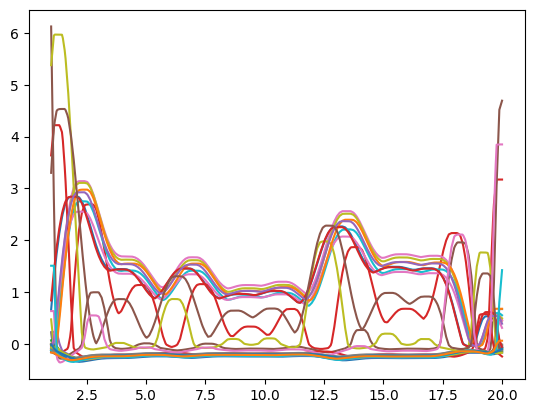

In [16]:

grid_convlayer1.plot()
plt.show()

In [78]:
def Hyper_parameter_GridSearch(hyperparams,parameter, grid):
    Total_accuracy_max = torch.tensor([0])
    Optimum_parameter = grid[0]

    
    
    # Obtenir l'attribut correspondant au paramètre spécifié
    attribute = getattr(hyperparams, parameter)
    
    for value in grid:
        # Modifier la valeur de l'attribut de la classe HyperParameters
        setattr(hyperparams, parameter, value)
        
        # Utiliser l'instance de HyperParameters pour effectuer les tests
        _, _, _, _, accuracy,n_best = Hyperparameter_Test(hyperparameters=hyperparams)
        Total_accuracy_max = torch.cat([Total_accuracy_max, torch.tensor([torch.max(accuracy)])])

    Optimum_parameter = grid[torch.argmax(Total_accuracy_max[1:])]
    return Optimum_parameter, torch.max(Total_accuracy_max[1:]),n_best


In [80]:
hyperparameters_opt=HyperParameters(n_epochs=50,n_conv_in=128,n_conv_in2=128,n_conv_in3=256,n_Flat_out=256,kernel_size_2=30,kernel_size_3=20)

Hyper_parameter_GridSearch(hyperparameters_opt,parameter="n_Flat_out",grid=(32,64, 128,256,512))

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_18264\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_18264\525065836.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 50/50 [00:04<00:00, 12.28it/s]


Précision moyenne = 84.246155 %
Précision max= 89.23077 %
Variance des précisions = 4.763674


100%|██████████| 50/50 [00:04<00:00, 12.20it/s]


Précision moyenne = 86.5077 %
Précision max= 92.30769 %
Variance des précisions = 13.795668


100%|██████████| 50/50 [00:04<00:00, 11.82it/s]


Précision moyenne = 85.43077 %
Précision max= 90.0 %
Variance des précisions = 3.3911307


100%|██████████| 50/50 [00:04<00:00, 11.66it/s]


Précision moyenne = 88.38461 %
Précision max= 92.30769 %
Variance des précisions = 7.130783


100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Précision moyenne = 89.26154 %
Précision max= 93.84615 %
Variance des précisions = 7.8966293


(512, tensor(93.8462), tensor(40))

In [ ]:
kernel_size_Opt,Max_acc=Hyper_parameter_GridSearch(hyperparameters_opt,grid = np.arange(25)[5:],parameter="kernel_size_3")

NameError: name 'Hyper_parameter_GridSearch' is not defined

In [ ]:
kernel_size_Opt,Max_acc

NameError: name 'kernel_size_Opt' is not defined

In [ ]:
hyperparameters_best=HyperParameters(n_epochs=50,n_conv_in=128,n_conv_in2=128,n_conv_in3=256,n_Flat_out=256,kernel_size_2=50,kernel_size_3=20)

In [ ]:
# grid = (32, 64, 128, 256, 512)
# results = []

# for n_conv_in in grid:
#     for n_conv_in2 in grid:
#         for n_conv_in3 in grid:
#             arguments_defaults["n_conv_in"] = n_conv_in
#             arguments_defaults["n_conv_in2"] = n_conv_in2
#             arguments_defaults["n_conv_in3"] = n_conv_in3

#             # Appel de votre fonction avec les paramètres spécifiés
#             _,_,_,_,result = Hyperparameter_Test(**arguments_defaults)

#             # Ajout du résultat à la liste des résultats
#             results.append(result)

# print(results)


In [ ]:
kernel_size_2,Max_acc

NameError: name 'Max_acc' is not defined

In [ ]:

# Hyper_parameter_GridSearch(parameter="n_conv_in3",grid=(32,64,128,256,512),n_epochs=25)

In [ ]:
grids = {
    "n_epochs": 25,
    "basis": B(knots=linspace(1,T,6),order=3),
    "granulation": 2000,
    "n_conv_in": (32,64, 128,256,512),
    "n_conv_in2": (32,64, 128,256,512),
    "n_conv_in3": (32,64, 128,256,512),
    "n_Flat_out": (32,64, 128,256,512),
    "stride_1": np.arange(8)[1:],
    "stride_2": np.arange(2)[1:],
    "stride_3": 1,
    "stride_pool_1": 2,
    "stride_pool_2": 2,
    "stride_pool_3": 1,
    "kernel_size_1": (50,75,150,300,400),
    "kernel_size_2": 50,
    "kernel_size_3": (5,10,15,20),
    "kernel_size_pool_1": np.arange(6)[3:],
    "kernel_size_pool_2": np.arange(4)[3:],
    "kernel_size_pool_3": (1,2),
    "dilation_1": 1,
    "dilation_2": 1,
    "dilation_3": 1,
    "dilation_pool_1": 1,
    "dilation_pool_2": 1,
    "dilation_pool_3": 1,
    "padding_1": np.arange(10)[1:],
    "padding_2": np.arange(10)[1:],
    "padding_3": np.arange(10)[1:],
    "padding_pool_1": np.arange(4)[1:],
    "padding_pool_2": np.arange(4)[1:],
    "padding_pool_3": np.arange(4)[1:],
    "opt": "Adam",
    "lr": 0.00089,
    "loss": nn.CrossEntropyLoss()
}


In [ ]:
param_list=["stride_1","stride_2","kernel_size_1","kernel_size_3","kernel_size_pool_1","kernel_size_pool_2","kernel_size_3","n_conv_in","n_conv_in2","n_conv_in3","n_Flat_out"]

In [ ]:
def Hyperparameter_Search(hyperparams,grids, parameters):
    best_parameters = {}
    best_accuracy = 0.0

    # Boucle sur les paramètres
    for param in parameters:
        # Boucle sur les grilles pour chaque paramètre
        print(param,type(param))
            # Appeler la fonction de Grid Search avec les paramètres spécifiés
        optimum_parameter, total_accuracy = Hyper_parameter_GridSearch(hyperparams,parameter=param,grid=grids[param])

        # Mettre à jour le meilleur résultat si nécessaire
        if total_accuracy > best_accuracy:
            best_parameters = hyperparams
            best_accuracy = total_accuracy
            hyperparams.param=optimum_parameter
    return best_parameters, best_accuracy


In [155]:
best_para,best_acc=Hyperparameter_Search(hyperparams=hyperparameters_opt,grids=grids,parameters=param_list)

stride_1 <class 'str'>


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7412\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7412\2871145439.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Précision moyenne = 84.98463 %
Précision max= 92.30769 %
Variance des précisions = 19.689404


100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


Précision moyenne = 83.10769 %
Précision max= 90.0 %
Variance des précisions = 12.412992


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Précision moyenne = 85.600006 %
Précision max= 90.76923 %
Variance des précisions = 9.371812


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Précision moyenne = 88.06155 %
Précision max= 93.07692 %
Variance des précisions = 10.8499


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Précision moyenne = 84.46154 %
Précision max= 89.23077 %
Variance des précisions = 5.3616686


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Précision moyenne = 82.41538 %
Précision max= 89.23077 %
Variance des précisions = 9.515999


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


Précision moyenne = 86.246155 %
Précision max= 91.53846 %
Variance des précisions = 9.700272


ValueError: too many values to unpack (expected 2)

In [151]:
hyperparameters_best.lr=0.01
hyperparameters_best.opt="SGD"
best_off,best_acc,n_opt=Hyper_parameter_GridSearch(hyperparameters_opt,parameter="n_conv_in",grid=(32,64, 128,256,512))


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7412\3210377230.py:78: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7412\2871145439.py:121: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 50/50 [00:02<00:00, 17.79it/s]


Précision moyenne = 88.0 %
Précision max= 91.53846 %
Variance des précisions = 4.661273


100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


Précision moyenne = 87.769226 %
Précision max= 93.84615 %
Variance des précisions = 11.671297


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


Précision moyenne = 81.96924 %
Précision max= 88.46153 %
Variance des précisions = 11.934789


100%|██████████| 50/50 [00:07<00:00,  6.37it/s]


Précision moyenne = 87.4 %
Précision max= 90.76923 %
Variance des précisions = 3.9340646


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]

Précision moyenne = 85.21538 %
Précision max= 90.76923 %
Variance des précisions = 10.996013


In [152]:
best_off,best_acc,n_opt

(64, tensor(93.8462), tensor(38))

In [107]:
hyperparameters_opt.n_conv_in

512

In [190]:
import gc
torch.cuda.empty_cache()
gc.collect()

0